# Potentials, Gradients and Soil Water Dynamics
## Modelling soil water dynamics in the vadose zone

This notebook looks at soil water potentials and the central question of soil water redistribution based on gradient depletion. We use the package CMF https://philippkraft.github.io/cmf to solve the richards equation in a 1D soil column. We experiment with different soil parameters, initial states and boundary conditions.

To do so, we define a 1m soil column with homogeneous definitions and explore the dynamics from different initial conditions towards an equilibrium state.

(cc) conrad.jackisch@tbt.tu-freiberg.de

In [1]:
#This block is loading some required standard packages
%pylab inline
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats

sns.set_style('whitegrid', {'grid.linestyle': u'--'})
matplotlib.rc('pdf', fonttype=42)

Populating the interactive namespace from numpy and matplotlib


## 1D soil column with the Richards equation as hydrological exchange function

We load the package CMF and generate a cell (soil column) at position (0,0,0) with an area of 1000 m².

In [2]:
import cmf
from datetime import datetime,timedelta

# initialise CMF project
project = cmf.project()

# initialise one cell at position (0,0,0) with an area of 1000 m2 and a water storage at the surface
cell = project.NewCell(x=0,y=0,z=0,area=1000, with_surfacewater=True)

We define a couple of soil water retention functions with the van Genuchten-Mualem model. These properties will be linked to soil layers (each 10 cm thick).

In [3]:
# parameterisation of soil hydraulic model van Genuchten-Mualem
r_curve1 = cmf.VanGenuchtenMualem(Ksat=5e-6*(24.*3600.),phi=0.5,alpha=0.035,n=1.5) #ksat in m/day >> 1.157e-05 m/s
r_curve2 = cmf.VanGenuchtenMualem(Ksat=1e-7*(24.*3600.),phi=0.5,alpha=0.155,n=1.8) #ksat in m/day 
r_curve3 = cmf.VanGenuchtenMualem(Ksat=1e-6*(24.*3600.),phi=0.5,alpha=0.055,n=1.8) #ksat in m/day 

#Carsel and Parrish 1988, doi:10.1029/WR024i005p00755
soilC   = cmf.VanGenuchtenMualem(theta_r=0.068, phi=0.38, alpha=0.008, n=1.09, Ksat= 0.200/100.*24.)
soilCL  = cmf.VanGenuchtenMualem(theta_r=0.095, phi=0.41, alpha=0.019, n=1.31, Ksat= 0.258/100.*24.)
soilL   = cmf.VanGenuchtenMualem(theta_r=0.078, phi=0.43, alpha=0.036, n=1.56, Ksat= 1.042/100.*24.)
soilLS  = cmf.VanGenuchtenMualem(theta_r=0.057, phi=0.43, alpha=0.124, n=2.28, Ksat=14.592/100.*24.)
soilS   = cmf.VanGenuchtenMualem(theta_r=0.045, phi=0.43, alpha=0.145, n=2.68, Ksat=29.700/100.*24.)
soilSC  = cmf.VanGenuchtenMualem(theta_r=0.100, phi=0.38, alpha=0.027, n=1.23, Ksat= 0.121/100.*24.)
soilSCL = cmf.VanGenuchtenMualem(theta_r=0.100, phi=0.39, alpha=0.059, n=1.48, Ksat= 1.308/100.*24.)
soilSI  = cmf.VanGenuchtenMualem(theta_r=0.034, phi=0.46, alpha=0.016, n=1.37, Ksat= 0.250/100.*24.)
soilSIC = cmf.VanGenuchtenMualem(theta_r=0.070, phi=0.36, alpha=0.005, n=1.09, Ksat= 0.021/100.*24.)
soilSICL= cmf.VanGenuchtenMualem(theta_r=0.089, phi=0.43, alpha=0.010, n=1.23, Ksat= 0.071/100.*24.)
soilSIL = cmf.VanGenuchtenMualem(theta_r=0.067, phi=0.45, alpha=0.020, n=1.41, Ksat= 0.450/100.*24.)
soilSL  = cmf.VanGenuchtenMualem(theta_r=0.065, phi=0.41, alpha=0.075, n=1.89, Ksat= 4.421/100.*24.)

In [4]:
# setup 10 soil layers with each 10 cm and the soil definitions from above
nlay=10
dlay=1./nlay
for i in range(nlay):
    depth = (i+1) * dlay
    cell.add_layer(depth,r_curve2)

# alternative layered setups:
#for i in range(20):
#    depth = (i+1) * 0.05
#    if i<10:
#        cell.add_layer(depth,soilSCL)
    #elif i<10:
    #    cell.add_layer(depth,soilSIL)
    #elif i<12:
    #    cell.add_layer(depth,soilS)
#    else:
#        cell.add_layer(depth,soilS)

#for i in range(10)[:6]:
#    depth = (i+1) * 0.1
#    cell.add_layer(depth,soilS)
#for i in range(10)[6:]:
#    depth = (i+1) * 0.1
#    cell.add_layer(depth,soilLS)



The cells have to be linked by the Richards equation...

In [5]:
cell.install_connection(cmf.Richards)

Because there is a large number of numerical procedures to actually solve the equation system of the soil water states and fluxes, we have to define the solver and set the starting time (irrelevant for this experiment).


In [6]:
# Definition des Lösers:
solver = cmf.CVodeKLU(project,1e-5)
#solver = cmf.RKFIntegrator(project,1e-6)
solver.t = cmf.Time(1,1,2011)

Now we have a soil column with 10 layers. The layers are connected through the Richards equation. As we discussed in the lecture, fluxes will only take place when there are gradients in the total hydraulic potential. The gradients are imposed through the initial conditions and the boundary conditions.

Let's explore a the soil column (like our sponge), which we define to be in contact with a groundwater body:

In [7]:
# define a connection to ground water as lower boundary
gw = project.NewOutlet('groundwater',x=0,y=0,z=-1)
# set groundwater potential (elevation of groundwater)
gw.potential = -1 
gw.is_source=True#False
# connect the lowest cell with the groundwater through the Richards equation
gw_flux=cmf.Richards(cell.layers[-1],gw)

# set the initial state in the (unsaturated) soil
# all layers have a potential of -5 m
cell.saturated_depth = 0.05

# define initial state at the soil surface
# 0 mm water for infiltration
cell.surfacewater.depth = 0.0

We are ready to start the model.

It will simulate 60 days running with a time step of 1 minute.

In [8]:
# start with initial conditions
potential = [cell.layers.potential]
moisture = [cell.layers.theta]
tstep = 1./60. #hour
# The run time loop:
for t in solver.run(solver.t,
                    solver.t + timedelta(days=60),
                    timedelta(hours=tstep)):
    potential.append(cell.layers.potential)
    moisture.append(cell.layers.theta)


In [9]:
#cell.layers[1].theta

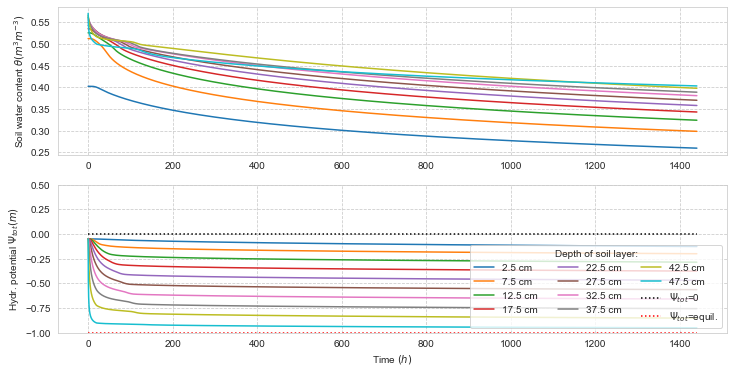

In [10]:
# plot results
figsize(12,6)
subplot(211)
plot(np.arange(len(moisture))*tstep,moisture)
ylabel(r'Soil water content $\theta (m^3m^{-3})$')
#xlabel(r'$time [h]$')


subplot(212)
for i in np.arange(np.shape(potential)[1]):
    #plot(np.arange(len(potential))*tstep,np.array(potential)[:,i],label=str(i*10+5)+' cm')
    plot(np.arange(len(potential))*tstep,np.array(potential)[:,i],label=str(i*5+2.5)+' cm')
plot([0,len(moisture)*tstep],[0,0],'k:',label=r'$\Psi_{tot}$=0')
plot([0,len(moisture)*tstep],[gw.potential,gw.potential],'r:',label=r'$\Psi_{tot}$=equil.')
ylabel(r'Hydr. potential $\Psi_{tot} (m)$')
xlabel(r'Time $(h)$')
ylim([-1,0.5])
legend(loc=4,ncol=3,title='Depth of soil layer:')
#savefig('dyn_col.pdf',bbox_inches='tight')

(0.0, 0.6)

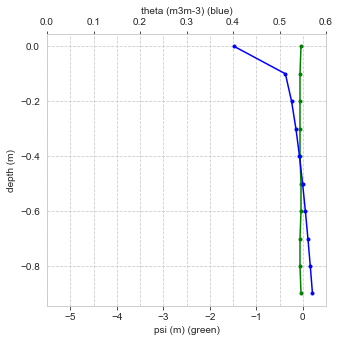

In [11]:
# create a figure and axes
fig = plt.figure(figsize=(5,5))
ax1 = plt.subplot(1,1,1)
ti = np.arange(len(moisture)*tstep).astype(str)

line1, = ax1.plot(potential[0],np.arange(nlay)*-dlay,'g.-')
ax1.set_xlabel('psi (m) (green)')
ax1.set_ylabel('depth (m)')
ax1.set_xlim(-5.5,+0.5)
ax1a = ax1.twiny()
line2, = ax1a.plot(moisture[0],np.arange(nlay)*-dlay,'b.-')
ax1a.set_xlabel('theta (m3m-3) (blue)')
ax1a.set_xlim(0.0,0.6)
#text1 = ax1.text(-1,-0.05,ti[0])


In [12]:
def drawframe(t):     
    line1.set_data(potential[t*nlay],np.arange(nlay)*-dlay)
    line2.set_data(moisture[t*nlay],np.arange(nlay)*-dlay)
    return (line1,line2)

In [13]:
from matplotlib import animation

# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=100, interval=100, blit=True)



In [14]:
from IPython.display import HTML
HTML(anim.to_html5_video())

In [21]:
# Set up formatting for the movie files
#Writer = animation.writers['ffmpeg']
#writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
#anim.save('SCL_S.mp4', writer=writer)

Text(0.5, 1.0, 'Dynamics of the total hydraulic potential')

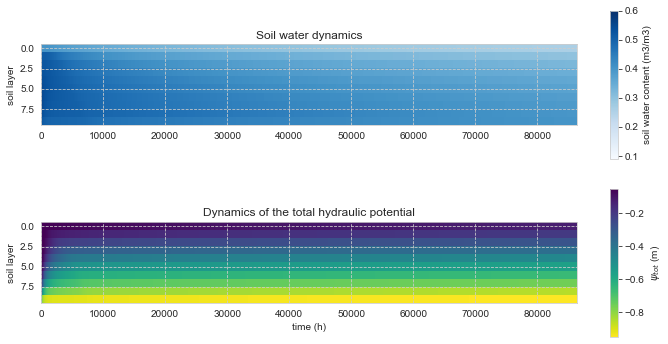

In [15]:
figsize(12,6)
subplot(211)
imshow(np.array(moisture).T,aspect=1300,cmap='Blues',vmin=0.09,vmax=0.6)
#xticks(np.arange(11)*(48/tstep),np.arange(11)*48)
#xlabel('Zeit (h)')
#xticklabels([])
ylabel('soil layer')
colorbar(label='soil water content (m3/m3)')
title('Soil water dynamics')

subplot(212)
imshow(np.array(potential).T,aspect=1300,cmap='viridis_r')
#xticks(np.arange(11)*(48/tstep),np.arange(11)*48)
xlabel('time (h)')
ylabel('soil layer')
colorbar(label='$\psi_{tot}$ (m)')
title('Dynamics of the total hydraulic potential')
#savefig('dyn_col_im.pdf',bbox_inches='tight')

Text(0.5, 1.0, 'Entwicklung der Bodenfeuchte')

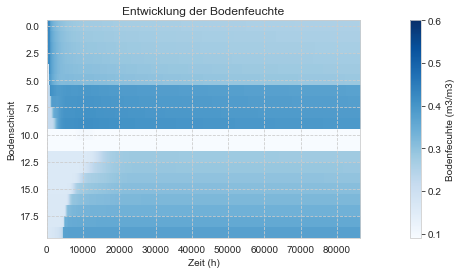

In [31]:
figsize(18,4)
imshow(np.array(moisture).T,aspect=3000,cmap='Blues',vmin=0.09,vmax=0.6)
#xticks(np.arange(11)*(48/tstep),np.arange(11)*48)
xlabel('time (h)')
ylabel('soil layer')
colorbar(label='soil water content (m3/m3)')
title('Soil water dynamics')

Text(0.5, 1.0, 'Entwicklung des totalen hydraulischen Potenzials')

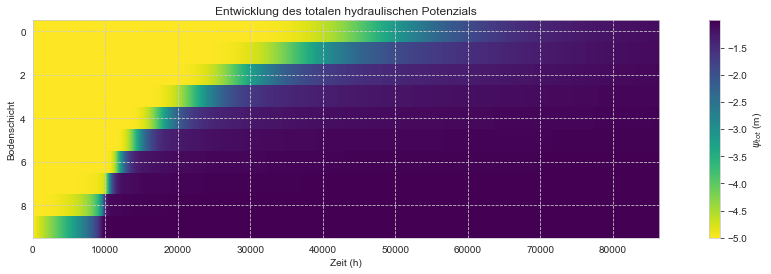

In [12]:
figsize(18,4)
imshow(np.array(potential).T,aspect=3000,cmap='viridis_r')
#xticks(np.arange(11)*(48/tstep),np.arange(11)*48)
xlabel('time (h)')
ylabel('soil layer')
colorbar(label='$\psi_{tot}$ (m)')
title('Dynamics of the total hydraulic potential')

## Please play with boundary conditions, initial states and soil parameters
As a first step, what happens if the soil is more dry or wet in the beginning?

You have to change the definitions accordingly. Since CMF stores the projects, it works best if your restart the whole kernel and re-run the entire notebook. If you simply re-run singe cells it might happen that either the initial state is not properly set or that earlier definitions are carried over.